# Classifier using LSTM layers

## 1. Importing Libraries

In [1]:
import torch

import numpy as np

data_folder = '../data/quickdraw'

EPOCHS = 10
BATCH_SIZE = 64

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 2. Data Preprocessing

### 2.1. Loading the data

In [2]:
import os


def get_categories_from_data(folder, n=None):
    categories = []
    files = os.listdir(folder)

    for file in files:
        fname = file[16:-7]
        if len(fname) > 0:
            categories.append(fname)

    if n is None:
        return categories

    return categories[:n]

#classes = get_categories_from_data(data_folder)
classes = ["calculator", "camera", "cell phone"]
class_id = dict(zip(classes, range(len(classes))))

calculator_data = np.load(f'../data/sketchrnn/sketchrnn_calculator.npz', allow_pickle=True, encoding='latin1')
camera_data = np.load(f'../data/sketchrnn/sketchrnn_camera.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/sketchrnn/sketchrnn_cell_phone.npz', allow_pickle=True, encoding='latin1')

class_id

{'calculator': 0, 'camera': 1, 'cell phone': 2}

In [3]:
def interpolate_strokes(strokes, target_length):
    """Interpolate a sequence of strokes to the target length."""
    current_length = len(strokes)
    if current_length == target_length:
        return strokes

    interpolated_strokes = np.zeros((target_length, 3), dtype=np.float32)
    interp_indices = np.floor(np.linspace(0, current_length-1, num=target_length)).astype(int)

    for i, idx in enumerate(interp_indices):
        interpolated_strokes[i] = strokes[idx]

    for i in range(target_length - 1):
        if interp_indices[i] != interp_indices[i + 1]:
            interpolated_strokes[i, 2] = strokes[interp_indices[i], 2]
        else:
            interpolated_strokes[i, 2] = 0

    # Ensure the last pen_state remains as the original last one
    interpolated_strokes[-1, 2] = strokes[-1, 2]

    return interpolated_strokes

def resize_and_normalize_drawings(data, size):
    """Resize and normalize drawing datasets."""
    resized_data = []
    for drawing in data['train']:
        resized_drawing = interpolate_strokes(drawing, size)
        resized_data.append(resized_drawing)
    return np.array(resized_data)

resized_calculator_drawings = resize_and_normalize_drawings(calculator_data, size=MAX_SEQ_LENGTH)
resized_camera_drawings = resize_and_normalize_drawings(camera_data, size=MAX_SEQ_LENGTH)
resized_cellphone_drawings = resize_and_normalize_drawings(cellphone_data, size=MAX_SEQ_LENGTH)

# TODO: Limitar dataset
resized_calculator_drawings = resized_calculator_drawings[:5120]
resized_cellphone_drawings = resized_cellphone_drawings[:5120]
resized_camera_drawings = resized_camera_drawings[:5120]

resized_camera_drawings.shape, resized_cellphone_drawings.shape, resized_calculator_drawings.shape

((5120, 95, 3), (5120, 95, 3), (5120, 95, 3))

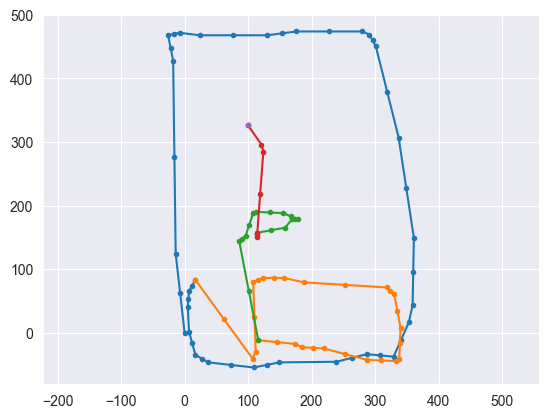

In [4]:
from matplotlib import pyplot as plt


def draw_strokes(data):
    """
    Draw stroke data from an array of (dx, dy, pen_state).

    Args:
    data (np.array): Stroke data array of shape (n, 3) where each row is (dx, dy, pen_state)
    """
    # Initialize a plot
    fig, ax = plt.subplots()

    # Starting point
    x, y = 0, 0
    points_x = [x]
    points_y = [y]

    # Iterate over the stroke data
    for dx, dy, pen_state in data:
        # Update position
        x += dx
        y += dy
        points_x.append(x)
        points_y.append(y)

        # If pen_state is 1, plot the current segment and start a new one
        if pen_state == 1:
            ax.plot(points_x, points_y, marker='.')
            points_x = [x]
            points_y = [y]

    # Plot the last segment
    ax.plot(points_x, points_y, marker='.')

    ax.axis('equal')
    plt.show()

draw_strokes(resized_calculator_drawings[0])

In [5]:
from sklearn.model_selection import train_test_split

def prepare_train_test_datasets(camera_drawings, cellphone_drawings, calculator_drawings, test_size=0.2):
    """
    Prepare training and testing datasets from the resized drawing data of cameras, cellphones, and calculators.

    Args:
    camera_drawings (np.array): Resized drawings of cameras.
    cellphone_drawings (np.array): Resized drawings of cellphones.
    calculator_drawings (np.array): Resized drawings of calculators.
    test_size (float): The proportion of the dataset to include in the test split.

    Returns:
    tuple: Train and test datasets containing features and labels.
    """
    # Labels for the datasets
    camera_labels = np.ones(camera_drawings.shape[0])  # Label 1 for cameras
    cellphone_labels = np.ones(cellphone_drawings.shape[0]) * 2  # Label 2 for cellphones
    calculator_labels = np.zeros(calculator_drawings.shape[0])  # Label 0 for calculators

    # Combine the drawings from all categories
    combined_drawings = np.concatenate([camera_drawings, cellphone_drawings, calculator_drawings], axis=0)
    combined_labels = np.concatenate([camera_labels, cellphone_labels, calculator_labels], axis=0)

    # Split into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(
        combined_drawings, combined_labels, test_size=test_size, random_state=42)

    return X_train, X_test, y_train, y_test

# Usage example
X_train, X_test, y_train, y_test = prepare_train_test_datasets(resized_camera_drawings, resized_cellphone_drawings, resized_calculator_drawings, test_size=0.2)

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12288, 95, 3), (12288,), (3072, 95, 3), (3072,))

In [7]:
from torch.utils.data import TensorDataset, DataLoader


def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.

    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    # Convert numpy arrays to TensorFlow tensors
    train_dataset = TensorDataset(torch.tensor(X_train).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device), torch.tensor(y_test, dtype=torch.long).to(device))

    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train, X_test, y_train, y_test)

# Setup DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
print(len(train_loader))
print(len(test_loader))

192
48


## 3. Model Building

### 3.1. Quantum Layer

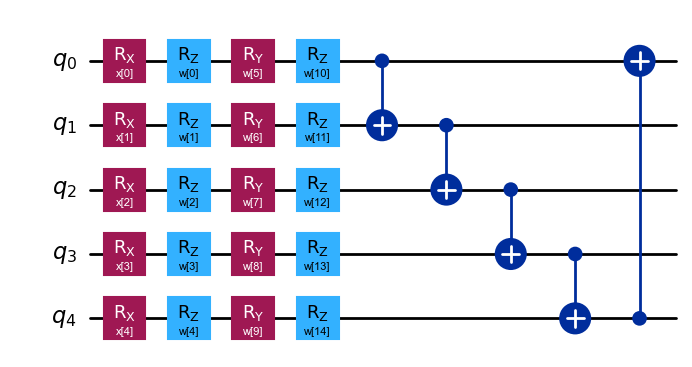

In [9]:
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)

    for i in range(n):
        circuit.rx(features[i], i)

    return circuit

def quantum_ansatz(n: int) -> QuantumCircuit:
    # Creamos un circuito cuántico con n qubits.
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)

    # Asumiendo que 'weights' es una lista de valores de peso,
    # y la longitud es suficiente para aplicar Rz a cada qubit.
    for i in range(n):
        circuit.rz(weights[i], i)

    # Aplicar más rotaciones, que en la imagen parecen ser Ry
    for i in range(n):
        circuit.ry(weights[n+i], i)

    for i in range(n):
        circuit.rz(weights[2*n+i], i)

    # Aplicar entrelazamiento con puertas CNOT
    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)

    return circuit

# Define and create QNN
def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)

    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qiskit_machine_learning.connectors import TorchConnector

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=5, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.pool1 = nn.AvgPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.pool2 = nn.AvgPool1d(kernel_size=2)
        
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.pool3 = nn.AvgPool1d(kernel_size=2)
        
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(num_features=128)
        self.pool4 = nn.AvgPool1d(kernel_size=2)

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        
        self.pool5 = nn.AvgPool1d(kernel_size=2)

        # Dense layers
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)

        # Quantum layer
        # self.fc3 = nn.Linear(64, n_qubits)
        # self.qnn = TorchConnector(create_qnn(n_qubits)[0])

        # Dense layer for classification
        self.fc4 = nn.Linear(64, num_categories)

        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        x = x.permute(0, 2, 1)

        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        # Reshape for LSTM
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Pool layer
        x = self.pool5(x)

        # Flatten the output for dense layer
        x = torch.flatten(x, 1)

        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Quantum layer
        # x = F.relu(self.fc3(x))
        # x = self.qnn(x)

        # Dense layer for classification
        x = F.softmax(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            # x = x.unsqueeze(0)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [11]:
checkpoint_filepath = 'models/2edition_lstm/best_model_weights_3classes.pth'

In [12]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)

            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
accuracy_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []

for epoch in range(100):
    model.train()

    total_loss = []
    
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())

        total_samples += 1

    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    
    accuracy_list.append(total_correct / len(train_loader.dataset))
    loss_list.append(sum(total_loss) / len(train_loader))
    
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)

  0%|          | 0/192 [00:00<?, ?it/s]C:\Users\yeray142\AppData\Local\Temp\ipykernel_12544\3657370401.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc4(x))
100%|██████████| 192/192 [00:02<00:00, 85.14it/s]


Epoch 1, Accuracy: 0.7683919270833334, Loss: 0.7868236809348067, Validation Accuracy: 0.8430989583333334, Validation Loss: 0.7060129642486572


100%|██████████| 192/192 [00:02<00:00, 95.09it/s]


Epoch 2, Accuracy: 0.86572265625, Loss: 0.6834298999359211, Validation Accuracy: 0.8606770833333334, Validation Loss: 0.6886418461799622


100%|██████████| 192/192 [00:02<00:00, 94.51it/s]


Epoch 3, Accuracy: 0.8798828125, Loss: 0.6685423475379745, Validation Accuracy: 0.8883463541666666, Validation Loss: 0.6624752879142761


100%|██████████| 192/192 [00:02<00:00, 95.06it/s]


Epoch 4, Accuracy: 0.890380859375, Loss: 0.6585023536657294, Validation Accuracy: 0.9000651041666666, Validation Loss: 0.647104799747467


100%|██████████| 192/192 [00:01<00:00, 96.85it/s]


Epoch 5, Accuracy: 0.8974609375, Loss: 0.6524473785733184, Validation Accuracy: 0.8981119791666666, Validation Loss: 0.6532612442970276


100%|██████████| 192/192 [00:02<00:00, 91.17it/s]


Epoch 6, Accuracy: 0.8992513020833334, Loss: 0.6499849759663144, Validation Accuracy: 0.8938802083333334, Validation Loss: 0.6557276248931885


100%|██████████| 192/192 [00:02<00:00, 94.67it/s]


Epoch 7, Accuracy: 0.9083658854166666, Loss: 0.6416905249158541, Validation Accuracy: 0.9078776041666666, Validation Loss: 0.6411860585212708


100%|██████████| 192/192 [00:02<00:00, 92.85it/s]


Epoch 8, Accuracy: 0.9082845052083334, Loss: 0.6405723805849751, Validation Accuracy: 0.8942057291666666, Validation Loss: 0.6562269330024719


100%|██████████| 192/192 [00:02<00:00, 95.00it/s]


Epoch 9, Accuracy: 0.9072265625, Loss: 0.641954867169261, Validation Accuracy: 0.9078776041666666, Validation Loss: 0.6411185264587402


100%|██████████| 192/192 [00:02<00:00, 95.96it/s]


Epoch 10, Accuracy: 0.9150390625, Loss: 0.6343312899892529, Validation Accuracy: 0.900390625, Validation Loss: 0.6482442021369934


100%|██████████| 192/192 [00:02<00:00, 88.47it/s]


Epoch 11, Accuracy: 0.909912109375, Loss: 0.6392613512774309, Validation Accuracy: 0.9140625, Validation Loss: 0.6348679661750793


100%|██████████| 192/192 [00:02<00:00, 94.75it/s]


Epoch 12, Accuracy: 0.9154459635416666, Loss: 0.6345629996309677, Validation Accuracy: 0.89453125, Validation Loss: 0.6533878445625305


100%|██████████| 192/192 [00:01<00:00, 96.14it/s]


Epoch 13, Accuracy: 0.9125162760416666, Loss: 0.636907002578179, Validation Accuracy: 0.9039713541666666, Validation Loss: 0.6444365382194519


100%|██████████| 192/192 [00:02<00:00, 95.22it/s]


Epoch 14, Accuracy: 0.9205729166666666, Loss: 0.6289884829893708, Validation Accuracy: 0.9182942708333334, Validation Loss: 0.6314528584480286


100%|██████████| 192/192 [00:02<00:00, 92.53it/s]


Epoch 15, Accuracy: 0.92578125, Loss: 0.6248359767099222, Validation Accuracy: 0.9137369791666666, Validation Loss: 0.6363992094993591


100%|██████████| 192/192 [00:02<00:00, 91.58it/s]


Epoch 16, Accuracy: 0.9219563802083334, Loss: 0.6275275088846684, Validation Accuracy: 0.9163411458333334, Validation Loss: 0.6325252652168274


100%|██████████| 192/192 [00:02<00:00, 86.90it/s]


Epoch 17, Accuracy: 0.9261067708333334, Loss: 0.6242826512704293, Validation Accuracy: 0.9156901041666666, Validation Loss: 0.635419487953186


100%|██████████| 192/192 [00:02<00:00, 91.70it/s]


Epoch 18, Accuracy: 0.9305013020833334, Loss: 0.6203819193566839, Validation Accuracy: 0.9020182291666666, Validation Loss: 0.6473446488380432


100%|██████████| 192/192 [00:02<00:00, 92.72it/s]


Epoch 19, Accuracy: 0.9265950520833334, Loss: 0.6238576952988902, Validation Accuracy: 0.9212239583333334, Validation Loss: 0.6294413208961487


100%|██████████| 192/192 [00:01<00:00, 96.16it/s]


Epoch 20, Accuracy: 0.929443359375, Loss: 0.6203624190141758, Validation Accuracy: 0.91015625, Validation Loss: 0.6398380398750305


100%|██████████| 192/192 [00:02<00:00, 95.67it/s]


Epoch 21, Accuracy: 0.934326171875, Loss: 0.6156041395540038, Validation Accuracy: 0.9222005208333334, Validation Loss: 0.6287553906440735


100%|██████████| 192/192 [00:02<00:00, 95.81it/s]


Epoch 22, Accuracy: 0.9336751302083334, Loss: 0.6165381499255697, Validation Accuracy: 0.9215494791666666, Validation Loss: 0.6275716423988342


100%|██████████| 192/192 [00:02<00:00, 95.70it/s]


Epoch 23, Accuracy: 0.936279296875, Loss: 0.6140111535787582, Validation Accuracy: 0.8912760416666666, Validation Loss: 0.658130943775177


100%|██████████| 192/192 [00:01<00:00, 96.76it/s]


Epoch 24, Accuracy: 0.9308268229166666, Loss: 0.6187369388838609, Validation Accuracy: 0.9173177083333334, Validation Loss: 0.6330297589302063


100%|██████████| 192/192 [00:02<00:00, 93.46it/s]


Epoch 25, Accuracy: 0.9370930989583334, Loss: 0.613079710242649, Validation Accuracy: 0.9176432291666666, Validation Loss: 0.6319718956947327


100%|██████████| 192/192 [00:02<00:00, 93.45it/s]


Epoch 26, Accuracy: 0.9388020833333334, Loss: 0.6109775925676028, Validation Accuracy: 0.9091796875, Validation Loss: 0.6418195366859436


100%|██████████| 192/192 [00:02<00:00, 94.37it/s]


Epoch 27, Accuracy: 0.9383138020833334, Loss: 0.6118793121228615, Validation Accuracy: 0.8938802083333334, Validation Loss: 0.6549548506736755


100%|██████████| 192/192 [00:02<00:00, 95.00it/s]


Epoch 28, Accuracy: 0.93017578125, Loss: 0.6204064674675465, Validation Accuracy: 0.912109375, Validation Loss: 0.637628972530365


100%|██████████| 192/192 [00:02<00:00, 95.63it/s]


Epoch 29, Accuracy: 0.9388020833333334, Loss: 0.6116005731746554, Validation Accuracy: 0.91796875, Validation Loss: 0.6306695342063904


100%|██████████| 192/192 [00:02<00:00, 92.47it/s]


Epoch 30, Accuracy: 0.9425455729166666, Loss: 0.6079776072874665, Validation Accuracy: 0.9166666666666666, Validation Loss: 0.631702721118927


100%|██████████| 192/192 [00:02<00:00, 95.11it/s]


Epoch 31, Accuracy: 0.9380696614583334, Loss: 0.6119833507885536, Validation Accuracy: 0.9228515625, Validation Loss: 0.6281365156173706


100%|██████████| 192/192 [00:02<00:00, 94.95it/s]


Epoch 32, Accuracy: 0.935302734375, Loss: 0.614817843772471, Validation Accuracy: 0.9228515625, Validation Loss: 0.6284109950065613


100%|██████████| 192/192 [00:02<00:00, 94.60it/s]


Epoch 33, Accuracy: 0.93505859375, Loss: 0.6154988659545779, Validation Accuracy: 0.9117838541666666, Validation Loss: 0.6381062269210815


100%|██████████| 192/192 [00:02<00:00, 95.55it/s]


Epoch 34, Accuracy: 0.93603515625, Loss: 0.6144300416732827, Validation Accuracy: 0.9225260416666666, Validation Loss: 0.6274570822715759


100%|██████████| 192/192 [00:02<00:00, 93.09it/s]


Epoch 35, Accuracy: 0.9365234375, Loss: 0.6136833156148592, Validation Accuracy: 0.9143880208333334, Validation Loss: 0.6349260807037354


100%|██████████| 192/192 [00:02<00:00, 84.64it/s]


Epoch 36, Accuracy: 0.9398600260416666, Loss: 0.6101380738740166, Validation Accuracy: 0.9231770833333334, Validation Loss: 0.6283596158027649


100%|██████████| 192/192 [00:02<00:00, 92.66it/s]


Epoch 37, Accuracy: 0.9414876302083334, Loss: 0.6097675223524371, Validation Accuracy: 0.9264322916666666, Validation Loss: 0.6254017353057861


100%|██████████| 192/192 [00:02<00:00, 85.70it/s]


Epoch 38, Accuracy: 0.9366861979166666, Loss: 0.61387910010914, Validation Accuracy: 0.9049479166666666, Validation Loss: 0.6436157822608948


100%|██████████| 192/192 [00:02<00:00, 93.54it/s]


Epoch 39, Accuracy: 0.9409993489583334, Loss: 0.6099447623516122, Validation Accuracy: 0.9241536458333334, Validation Loss: 0.6252824664115906


100%|██████████| 192/192 [00:02<00:00, 91.39it/s]


Epoch 40, Accuracy: 0.9443359375, Loss: 0.6054346061622103, Validation Accuracy: 0.9254557291666666, Validation Loss: 0.6248115301132202


100%|██████████| 192/192 [00:02<00:00, 93.69it/s]


Epoch 41, Accuracy: 0.949951171875, Loss: 0.6006845353792111, Validation Accuracy: 0.9267578125, Validation Loss: 0.6221044659614563


100%|██████████| 192/192 [00:02<00:00, 94.84it/s]


Epoch 42, Accuracy: 0.9453938802083334, Loss: 0.6050042134399215, Validation Accuracy: 0.9195963541666666, Validation Loss: 0.6284165978431702


100%|██████████| 192/192 [00:02<00:00, 92.55it/s]


Epoch 43, Accuracy: 0.9454752604166666, Loss: 0.6054246701921026, Validation Accuracy: 0.9156901041666666, Validation Loss: 0.6347363591194153


100%|██████████| 192/192 [00:02<00:00, 93.55it/s]


Epoch 44, Accuracy: 0.945068359375, Loss: 0.6052012667059898, Validation Accuracy: 0.9215494791666666, Validation Loss: 0.6283507943153381


100%|██████████| 192/192 [00:02<00:00, 95.04it/s]


Epoch 45, Accuracy: 0.948486328125, Loss: 0.6020583386222521, Validation Accuracy: 0.921875, Validation Loss: 0.629854679107666


100%|██████████| 192/192 [00:02<00:00, 93.98it/s]


Epoch 46, Accuracy: 0.9462890625, Loss: 0.604343144223094, Validation Accuracy: 0.91796875, Validation Loss: 0.6332818865776062


100%|██████████| 192/192 [00:02<00:00, 95.36it/s]


Epoch 47, Accuracy: 0.9488118489583334, Loss: 0.6018779957666993, Validation Accuracy: 0.9150390625, Validation Loss: 0.6342617869377136


100%|██████████| 192/192 [00:02<00:00, 95.35it/s]


Epoch 48, Accuracy: 0.9544270833333334, Loss: 0.5958106676116586, Validation Accuracy: 0.9192708333333334, Validation Loss: 0.6318501830101013


100%|██████████| 192/192 [00:02<00:00, 92.44it/s]


Epoch 49, Accuracy: 0.9512532552083334, Loss: 0.5998700261116028, Validation Accuracy: 0.9222005208333334, Validation Loss: 0.6274799108505249


100%|██████████| 192/192 [00:02<00:00, 94.23it/s]


Epoch 50, Accuracy: 0.9541015625, Loss: 0.5971657702078422, Validation Accuracy: 0.9189453125, Validation Loss: 0.6304908394813538


100%|██████████| 192/192 [00:02<00:00, 94.98it/s]


Epoch 51, Accuracy: 0.9484049479166666, Loss: 0.6018581145132581, Validation Accuracy: 0.9241536458333334, Validation Loss: 0.6269479393959045


100%|██████████| 192/192 [00:02<00:00, 94.06it/s]


Epoch 52, Accuracy: 0.9473470052083334, Loss: 0.6034379970903198, Validation Accuracy: 0.9231770833333334, Validation Loss: 0.6271379590034485


100%|██████████| 192/192 [00:02<00:00, 92.82it/s]


Epoch 53, Accuracy: 0.9507649739583334, Loss: 0.5994123394290606, Validation Accuracy: 0.9205729166666666, Validation Loss: 0.6291069388389587


100%|██████████| 192/192 [00:02<00:00, 93.68it/s]


Epoch 54, Accuracy: 0.952392578125, Loss: 0.5986789921298623, Validation Accuracy: 0.9241536458333334, Validation Loss: 0.6270509958267212


100%|██████████| 192/192 [00:02<00:00, 94.46it/s]


Epoch 55, Accuracy: 0.9500325520833334, Loss: 0.6004944862797856, Validation Accuracy: 0.9222005208333334, Validation Loss: 0.6277788281440735


100%|██████████| 192/192 [00:02<00:00, 94.05it/s]


Epoch 56, Accuracy: 0.954833984375, Loss: 0.5953108392034968, Validation Accuracy: 0.9173177083333334, Validation Loss: 0.6328898072242737


100%|██████████| 192/192 [00:02<00:00, 93.37it/s]


Epoch 57, Accuracy: 0.9536946614583334, Loss: 0.5977337794999281, Validation Accuracy: 0.9205729166666666, Validation Loss: 0.6286383867263794


100%|██████████| 192/192 [00:02<00:00, 94.24it/s]


Epoch 58, Accuracy: 0.9521484375, Loss: 0.5981064277390639, Validation Accuracy: 0.9254557291666666, Validation Loss: 0.6245263814926147


100%|██████████| 192/192 [00:02<00:00, 94.58it/s]


Epoch 59, Accuracy: 0.9556477864583334, Loss: 0.5947551016385356, Validation Accuracy: 0.9186197916666666, Validation Loss: 0.6320037245750427


100%|██████████| 192/192 [00:02<00:00, 91.81it/s]


Epoch 60, Accuracy: 0.959716796875, Loss: 0.5910548477744063, Validation Accuracy: 0.9205729166666666, Validation Loss: 0.6291406750679016


100%|██████████| 192/192 [00:02<00:00, 94.80it/s]


Epoch 61, Accuracy: 0.95703125, Loss: 0.5929361712187529, Validation Accuracy: 0.9205729166666666, Validation Loss: 0.6309201717376709


100%|██████████| 192/192 [00:02<00:00, 95.10it/s]


Epoch 62, Accuracy: 0.9532063802083334, Loss: 0.5975870378315449, Validation Accuracy: 0.9137369791666666, Validation Loss: 0.6346117854118347


100%|██████████| 192/192 [00:02<00:00, 93.59it/s]


Epoch 63, Accuracy: 0.955078125, Loss: 0.5956137593214711, Validation Accuracy: 0.9228515625, Validation Loss: 0.627193033695221


100%|██████████| 192/192 [00:02<00:00, 93.38it/s]


Epoch 64, Accuracy: 0.9585774739583334, Loss: 0.5925385362158219, Validation Accuracy: 0.9228515625, Validation Loss: 0.6284343600273132


100%|██████████| 192/192 [00:02<00:00, 94.52it/s]


Epoch 65, Accuracy: 0.9579264322916666, Loss: 0.5932285307596127, Validation Accuracy: 0.9176432291666666, Validation Loss: 0.6322289705276489


100%|██████████| 192/192 [00:02<00:00, 92.96it/s]


Epoch 66, Accuracy: 0.9512532552083334, Loss: 0.5987685456251105, Validation Accuracy: 0.9150390625, Validation Loss: 0.6355025172233582


100%|██████████| 192/192 [00:02<00:00, 93.36it/s]


Epoch 67, Accuracy: 0.9593098958333334, Loss: 0.5914967122177283, Validation Accuracy: 0.9235026041666666, Validation Loss: 0.6271052956581116


100%|██████████| 192/192 [00:02<00:00, 88.00it/s]


Epoch 68, Accuracy: 0.9495442708333334, Loss: 0.6016921832536658, Validation Accuracy: 0.9173177083333334, Validation Loss: 0.6323923468589783


100%|██████████| 192/192 [00:02<00:00, 88.76it/s]


Epoch 69, Accuracy: 0.9559733072916666, Loss: 0.5947850197553635, Validation Accuracy: 0.9248046875, Validation Loss: 0.624884307384491


100%|██████████| 192/192 [00:02<00:00, 88.75it/s]


Epoch 70, Accuracy: 0.95849609375, Loss: 0.592798602146407, Validation Accuracy: 0.9222005208333334, Validation Loss: 0.6273640394210815


100%|██████████| 192/192 [00:02<00:00, 87.33it/s]


Epoch 71, Accuracy: 0.9619954427083334, Loss: 0.5894021221126119, Validation Accuracy: 0.9228515625, Validation Loss: 0.6283982396125793


100%|██████████| 192/192 [00:02<00:00, 93.16it/s]


Epoch 72, Accuracy: 0.9580078125, Loss: 0.5930606120576462, Validation Accuracy: 0.9254557291666666, Validation Loss: 0.6255131363868713


100%|██████████| 192/192 [00:02<00:00, 93.35it/s]


Epoch 73, Accuracy: 0.96240234375, Loss: 0.5889104623347521, Validation Accuracy: 0.9212239583333334, Validation Loss: 0.6286457180976868


100%|██████████| 192/192 [00:02<00:00, 94.43it/s]


Epoch 74, Accuracy: 0.9578450520833334, Loss: 0.5934890195106467, Validation Accuracy: 0.923828125, Validation Loss: 0.6274799704551697


100%|██████████| 192/192 [00:02<00:00, 94.63it/s]


Epoch 75, Accuracy: 0.9574381510416666, Loss: 0.5936871683225036, Validation Accuracy: 0.919921875, Validation Loss: 0.630632221698761


100%|██████████| 192/192 [00:02<00:00, 94.56it/s]


Epoch 76, Accuracy: 0.9561360677083334, Loss: 0.5949633956576387, Validation Accuracy: 0.9134114583333334, Validation Loss: 0.637069821357727


100%|██████████| 192/192 [00:02<00:00, 94.41it/s]


Epoch 77, Accuracy: 0.95849609375, Loss: 0.5921509532878796, Validation Accuracy: 0.9244791666666666, Validation Loss: 0.6257424354553223


100%|██████████| 192/192 [00:02<00:00, 90.02it/s]


Epoch 78, Accuracy: 0.96142578125, Loss: 0.5893868934363127, Validation Accuracy: 0.9231770833333334, Validation Loss: 0.6271392703056335


100%|██████████| 192/192 [00:02<00:00, 95.76it/s]


Epoch 79, Accuracy: 0.9624837239583334, Loss: 0.5886686695739627, Validation Accuracy: 0.9212239583333334, Validation Loss: 0.6296784281730652


100%|██████████| 192/192 [00:02<00:00, 94.02it/s]


Epoch 80, Accuracy: 0.960205078125, Loss: 0.5911210722600421, Validation Accuracy: 0.9235026041666666, Validation Loss: 0.6277466416358948


100%|██████████| 192/192 [00:02<00:00, 95.10it/s]


Epoch 81, Accuracy: 0.9599609375, Loss: 0.5906740895782908, Validation Accuracy: 0.9274088541666666, Validation Loss: 0.6233966946601868


100%|██████████| 192/192 [00:02<00:00, 93.23it/s]


Epoch 82, Accuracy: 0.9658203125, Loss: 0.5856262231245637, Validation Accuracy: 0.9254557291666666, Validation Loss: 0.6246678829193115


100%|██████████| 192/192 [00:02<00:00, 93.97it/s]


Epoch 83, Accuracy: 0.9637858072916666, Loss: 0.5869504539296031, Validation Accuracy: 0.9091796875, Validation Loss: 0.6396687626838684


100%|██████████| 192/192 [00:02<00:00, 94.48it/s]


Epoch 84, Accuracy: 0.9646809895833334, Loss: 0.5862874705344439, Validation Accuracy: 0.9186197916666666, Validation Loss: 0.6317457556724548


100%|██████████| 192/192 [00:02<00:00, 93.89it/s]


Epoch 85, Accuracy: 0.9678548177083334, Loss: 0.583677388417224, Validation Accuracy: 0.92578125, Validation Loss: 0.6256342530250549


100%|██████████| 192/192 [00:02<00:00, 94.23it/s]


Epoch 86, Accuracy: 0.9627278645833334, Loss: 0.5881242410590252, Validation Accuracy: 0.9231770833333334, Validation Loss: 0.6278489232063293


100%|██████████| 192/192 [00:02<00:00, 95.30it/s]


Epoch 87, Accuracy: 0.962646484375, Loss: 0.5883784436931213, Validation Accuracy: 0.9169921875, Validation Loss: 0.6322188973426819


100%|██████████| 192/192 [00:02<00:00, 93.93it/s]


Epoch 88, Accuracy: 0.96142578125, Loss: 0.5897144535556436, Validation Accuracy: 0.9173177083333334, Validation Loss: 0.6325420141220093


100%|██████████| 192/192 [00:02<00:00, 94.43it/s]


Epoch 89, Accuracy: 0.9607747395833334, Loss: 0.5904730012019476, Validation Accuracy: 0.9254557291666666, Validation Loss: 0.6247105598449707


100%|██████████| 192/192 [00:02<00:00, 94.03it/s]


Epoch 90, Accuracy: 0.9627278645833334, Loss: 0.588529083567361, Validation Accuracy: 0.9222005208333334, Validation Loss: 0.6282379627227783


100%|██████████| 192/192 [00:02<00:00, 94.91it/s]


Epoch 91, Accuracy: 0.961181640625, Loss: 0.5898085956772169, Validation Accuracy: 0.9261067708333334, Validation Loss: 0.6246033906936646


100%|██████████| 192/192 [00:02<00:00, 91.26it/s]


Epoch 92, Accuracy: 0.9649251302083334, Loss: 0.5863295703505477, Validation Accuracy: 0.9156901041666666, Validation Loss: 0.6345775127410889


100%|██████████| 192/192 [00:02<00:00, 94.34it/s]


Epoch 93, Accuracy: 0.96435546875, Loss: 0.5866358534743389, Validation Accuracy: 0.9274088541666666, Validation Loss: 0.622305691242218


100%|██████████| 192/192 [00:02<00:00, 94.08it/s]


Epoch 94, Accuracy: 0.9658203125, Loss: 0.5849527465179563, Validation Accuracy: 0.9283854166666666, Validation Loss: 0.6225450038909912


100%|██████████| 192/192 [00:02<00:00, 94.97it/s]


Epoch 95, Accuracy: 0.966796875, Loss: 0.584116468206048, Validation Accuracy: 0.9280598958333334, Validation Loss: 0.6228075623512268


100%|██████████| 192/192 [00:02<00:00, 93.42it/s]


Epoch 96, Accuracy: 0.962158203125, Loss: 0.5890864552929997, Validation Accuracy: 0.9046223958333334, Validation Loss: 0.6455915570259094


100%|██████████| 192/192 [00:02<00:00, 95.02it/s]


Epoch 97, Accuracy: 0.96484375, Loss: 0.5859979701538881, Validation Accuracy: 0.9261067708333334, Validation Loss: 0.6248897314071655


100%|██████████| 192/192 [00:02<00:00, 94.41it/s]


Epoch 98, Accuracy: 0.9639485677083334, Loss: 0.5869825749347607, Validation Accuracy: 0.9228515625, Validation Loss: 0.6276034712791443


100%|██████████| 192/192 [00:02<00:00, 90.78it/s]


Epoch 99, Accuracy: 0.9619954427083334, Loss: 0.5893305925031503, Validation Accuracy: 0.9173177083333334, Validation Loss: 0.633552074432373


100%|██████████| 192/192 [00:02<00:00, 93.96it/s]


Epoch 100, Accuracy: 0.9617513020833334, Loss: 0.5890748280410966, Validation Accuracy: 0.9254557291666666, Validation Loss: 0.6251110434532166


## 5. Model Evaluation

### 5.1. Plotting the Training and Validation Loss

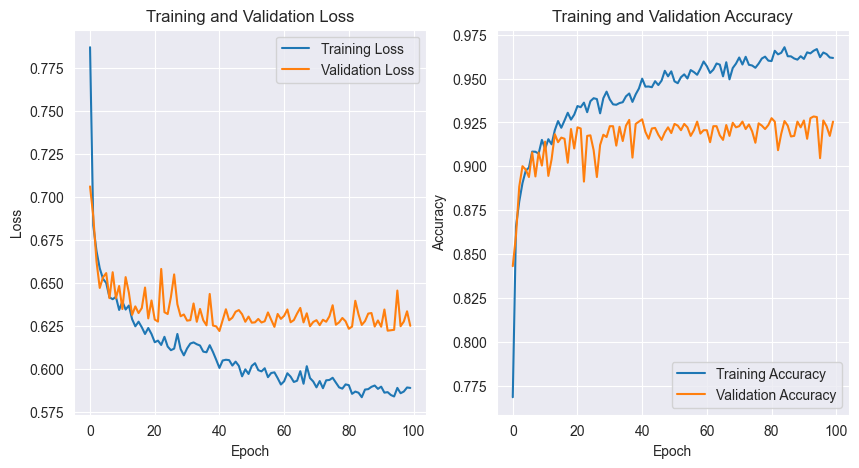

In [13]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [14]:
model = HybridNN(input_shape, num_categories=len(classes), fname=checkpoint_filepath)

In [15]:
outputs = model.predict(X_test)

C:\Users\yeray142\AppData\Local\Temp\ipykernel_12544\3657370401.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc4(x))


In [16]:
y_pred = np.argmax(outputs, axis=1)
y_pred

array([2, 2, 2, ..., 0, 0, 2], dtype=int64)

In [17]:
INDEX = 6

out = model.predict([X_test[:2500][INDEX]])
print("Predicted class:", classes[np.argmax(out)])
print("True class:", classes[y_test[INDEX].astype(int)])

Predicted class: calculator
True class: calculator


C:\Users\yeray142\AppData\Local\Temp\ipykernel_12544\3657370401.py:94: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\yeray142\AppData\Local\Temp\ipykernel_12544\3657370401.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc4(x))
